In [1]:
import subprocess
import os
import glob
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astropy.units as u
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

from astropy.time import Time
from astropy.coordinates import SkyCoord
from scipy.special import iv
from astropy.constants import c

# Formatting opinions
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.width'] = 2.5
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 9.0
mpl.rcParams['ytick.minor.size'] = .0

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.major.width'] = 2.5
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.size'] = 9.0
mpl.rcParams['xtick.minor.size'] = 4.0
mpl.rcParams['xtick.labelbottom'] = True


mpl.rcParams['axes.linewidth'] = 1.5

# Function for putting UTC on top of axis
def FormatAxis(ax, mjd, dt = 10, interval=60):
    ax[0].set_xlabel('Observing Date (UTC)', fontfamily='serif')  
    ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax[0].set_xlim(Time(mjd[0] - dt, format='mjd').datetime,Time(mjd[-1] + dt, format='mjd').datetime)
    ax[0].xaxis.set_label_position('top') 
    xformatter = mdates.DateFormatter('%Y-%m-%d')
    plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    ax[0].tick_params(axis='x', which='major',rotation=15, labeltop=True, labelbottom=False)
    xlabels = ax[0].get_xticklabels()
    ax[0].set_xticklabels(xlabels, rotation=15, ha='left')

    # Format secondary x-axis
    mjd_ax = ax[-1].secondary_xaxis('bottom', functions=(plot2mjd, mjd2plot))
    mjd_ax.set_xlabel('Observing Date (MJD)', fontfamily='serif')  
    mjd_ax.tick_params(which='major', direction='in', length = 0.0, width = 0.0)
    plt.draw()

    # Extract the labels
    mjd_ticks = []
    labels = ax[0].get_xticklabels(which='major')
    for lab in labels:
        mjd_ticks.append(lab.get_text() + 'T00:00:00')

    # Line up MJD and Datetime labels 
    mjd_ticks = (Time(mjd_ticks, format='isot').mjd).astype(int)
    mjd_ax.set_xticks(mjd_ticks, labels = mjd_ticks)
    
def plot2mjd(t):
    '''Convert from matplotlib plot date to mjd'''
    return Time(t, format="plot_date", scale='utc').mjd

def mjd2plot(mjd):
    '''Convert from mjd to matplotlib plot'''
    return Time(mjd, format="mjd", scale='utc').plot_date

def initialize_maxi_curve(fname, cutoff=10):
    data = np.genfromtxt(fname)
    data[:,0] = (data[:,1] * 0.5 + data[:,0] * 0.5)
    data[:,1] = np.ones(data.shape[0]) * 0.5

    return data[cutoff:,:]

## Load in the radio data and calculate spectral indices

In [2]:
data = pd.read_csv('files/SW1727_Radio.csv')  # Load the radio data from a CSV file
data['Midpoint (DT)'] = Time(data['Midpoint (MJD)'], format='mjd').datetime  # Convert MJD to datetime for easier plotting

# Initialize lists to store spectral index information
alpha_arr = []          # List to store calculated spectral indices (alpha)
alpha_mjd = []          # List to store the corresponding MJD values
alpha_err_arr = []      # List to store errors in the spectral indices
alpha_telescope = []    # List to store the telescope names for each spectral index

# Iterate through unique observation dates (MJD) to calculate spectral indices
for mjd in np.unique(data['Midpoint (MJD)']):

    # Get the telescope names corresponding to the current MJD
    index = (data['Midpoint (MJD)'] == mjd)
    tele = data['Telescope'][index]

    # Ensure there is no cross-talk between telescopes (only one telescope per MJD)
    if len(np.unique(tele)) > 1:
        print('Cross Talk Between the Telescopes')  # Warn if multiple telescopes are present
        break

    tele = np.unique(tele)[0]  # Extract the unique telescope name
    
    # Extract flux, flux error, and frequency values for the current MJD
    flux = np.array(data['Integrated flux (mJy)'][index])
    flux_err = np.array(data['Error (mJy)'][index])
    freq = np.array(data['Frequency (GHz)'][index])    

    # Sort the data by frequency for consistent calculations
    argsort = np.argsort(freq)
    freq = freq[argsort]
    flux = flux[argsort]
    flux_err = flux_err[argsort]
    
    # Perform a multi-point linear fit if there are more than two frequency points
    if flux.size >= 2:
        # Perform a weighted linear fit in log-log space
        logflux  = np.log(flux)
        dlogflux = abs(flux_err / flux)
        logfreq  = np.log(freq)
        fit, cov = np.polyfit(logfreq, logflux, w=1. / dlogflux, deg=1, cov='unscaled')

        # Extract the spectral index (alpha) and its error from the fit
        alpha = fit[0]
        alpha_err = cov[0, 0] ** 0.5

        # Append the results to the respective lists
        alpha_telescope.append(tele)
        alpha_mjd.append(mjd)        
        alpha_arr.append(alpha)
        alpha_err_arr.append(alpha_err)

    # Optionally plot the spectral index (disabled by default)
    plot = False
    if flux.size > 1 and plot:
        # Create a directory for saving plots if it doesn't exist
        if not os.path.exists('spectral_pngs/'):
            os.mkdir('spectral_pngs/') 

        # Plot the spectral index and save the figure
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.errorbar(np.log(freq), np.log(flux), yerr=abs(flux_err / flux), fmt='o')
        ax.errorbar(np.log(freq), np.log(freq) * fit[0] + fit[1], fmt='-', c='r', label='alpha={:.3f} +/- {:.3f}'.format(fit[0], alpha_err))
        ax.set_ylabel('Ln Flux Density (log mJy)')
        ax.set_xlabel('Ln Frequency (log GHz)')
        ax.legend()
        plt.savefig('spectral_pngs/mjd{}_{}.png'.format(mjd, tele))
        plt.clf()
        plt.close()        

# Convert the lists to NumPy arrays for easier manipulation
alpha_arr       = np.array(alpha_arr)       
alpha_mjd       = np.array(alpha_mjd)       
alpha_err_arr   = np.array(alpha_err_arr)   
alpha_telescope = np.array(alpha_telescope)

## Calculate a 10-GHz scaled lightcurve using the nearest spectral index

In [3]:
# Iterate through the MJD array and find the nearest spectral index for each observation
nearest_index = []
for mjd in data['Midpoint (MJD)']: 
    # Find the index of the closest spectral index in time (MJD)
    nearest_index.append(np.argmin(abs(alpha_mjd - mjd)))

# Convert the list of nearest indices to a NumPy array for easier manipulation
nearest_index = np.array(nearest_index)

# Scale the flux to a reference frequency of 10 GHz using the nearest spectral index
alpha_scaled = alpha_arr[nearest_index]  # Spectral index corresponding to the nearest time
alpha_scaled_err = alpha_err_arr[nearest_index]  # Error in the spectral index
flux_scaled = data['Integrated flux (mJy)'] * (10.0 / data['Frequency (GHz)']) ** (alpha_scaled)  # Scaled flux

# Calculate the error on the scaled flux, including contributions from both flux and spectral index uncertainties
flux_scaled_err = (
    (data['Error (mJy)'] * (10.0 / data['Frequency (GHz)']) ** (alpha_scaled)) ** 2 +  # Flux error contribution
    (data['Integrated flux (mJy)'] * (10.0 / data['Frequency (GHz)']) ** (alpha_scaled) * 
     np.log(10.0 / data['Frequency (GHz)']) * alpha_scaled_err) ** 2  # Spectral index error contribution
) ** 0.5

# Select data points with frequencies between 1 GHz and 100 GHz, excluding e-MERLIN due to VLBI concerns
scaled_index = np.where(
    (data['Frequency (GHz)'] < 100.) &  # Upper frequency limit
    (data['Frequency (GHz)'] > 1.) &   # Lower frequency limit
    (data['Telescope'] != 'e-MERLIN')  # Exclude e-MERLIN telescope
)[0]

## Make the MAXI/GSC HID from the On-Demand Data Products

In [6]:
# Define relevant functions
def calc_HR(hard, soft):
    # Calculate the Hardness Ratio (HR) and its error
    HR = hard[0] / soft[0]  # Hardness ratio: hard flux divided by soft flux
    HR_err = HR * ((soft[1] / soft[0]) ** 2 + (hard[1] / hard[0]) ** 2) ** 0.5  # Propagate errors
    return [HR, HR_err]

def weighted_average(data):
    # Calculate the weighted average and its error
    avg = np.average(data[:, 0], weights=data[:, 1] ** (-2))  # Weighted average using inverse variance
    avg_err = np.sum(data[:, 1] ** (-2)) ** (-0.5)  # Error on the weighted average
    return [avg, avg_err]

# Load the on-demand MAXI/GSC data products
# These files contain soft (2.0-6.0 keV) and hard (6.0-20.0 keV) X-ray light curves
maxi_soft = initialize_maxi_curve('files/Swift_J1727_2.0-6.0keV_gsclc.dat')  # Soft X-ray data
maxi_hard = initialize_maxi_curve('files/Swift_J1727_6.0-20.0keV_gsclc.dat')  # Hard X-ray data

# Filter the data to only include points after the outburst onset
# This ensures we only analyze statistically significant HR values
index = np.where(maxi_soft[:, 2] > 1.0)[0][0] - 1  # Find the first significant soft flux point
maxi_soft = maxi_soft[index:, :]  # Filter soft X-ray data
maxi_hard = maxi_hard[index:, :]  # Filter hard X-ray data

# Combine soft and hard X-ray data to calculate total flux and its error
maxi_total = maxi_soft[:, [0, 1, 2, 3]] + maxi_hard[:, [0, 1, 2, 3]]  # Sum soft and hard fluxes
maxi_total[:, 3] = (maxi_soft[:, 3] ** 2 + maxi_hard[:, 3] ** 2) ** 0.5  # Combine errors in quadrature

# Extract useful components for further analysis
t_arr = maxi_soft[:, 0]  # Time array
soft = maxi_soft[:, [2, 3]]  # Soft flux and its error
hard = maxi_hard[:, [2, 3]]  # Hard flux and its error
total = maxi_total[:, [2, 3]]  # Total flux and its error

# Initialize a 2D list to store Hardness-Intensity Diagram (HID) information
# HID structure: [time, time error, hardness ratio, hardness ratio error, total flux, total flux error]
HID = [[], [], [], [], [], []]

# Adaptive averaging parameters
k = 0  # Starting index for the current bin
dk = 1  # Bin size increment
threshold = 3  # Significance threshold for stopping a bin

# Perform adaptive averaging to calculate HID points
# A bin will stop if any of the following conditions are met:
# 1. The next bin exceeds the threshold significance (avoids over-averaging).
# 2. A large gap in time (e.g., due to sun constraints) is encountered.
# 3. The end of the data is reached.
# 4. The current bin meets the threshold significance.

while True:
    # Calculate weighted averages for soft, hard, and total fluxes in the current bin
    soft_avg = weighted_average(soft[k:k + dk, :])  # Weighted average of soft flux
    hard_avg = weighted_average(hard[k:k + dk, :])  # Weighted average of hard flux
    total_avg = weighted_average(total[k:k + dk, :])  # Weighted average of total flux

    # Check if the current bin meets the threshold significance
    if soft_avg[0] >= threshold * soft_avg[1] and hard_avg[0] >= threshold * hard_avg[1]:
        # Calculate the midpoint time and its error for the current bin
        t = np.mean(t_arr[k:k + dk])  # Midpoint time
        dt = (np.amax(t_arr[k:k + dk]) - np.amin(t_arr[k:k + dk])) * 0.5 + 0.5  # Time error

        # Calculate the hardness ratio (HR) and its error
        HR_i = calc_HR(hard_avg, soft_avg)

        # Append the calculated values to the HID list
        HID[0].append(t)  # Time
        HID[1].append(dt)  # Time error
        HID[2].append(HR_i[0])  # Hardness ratio
        HID[3].append(HR_i[1])  # Hardness ratio error
        HID[4].append(total_avg[0])  # Total flux
        HID[5].append(total_avg[1])  # Total flux error

        # Move to the next bin
        k = k + dk
        dk = 1  # Reset bin size increment

    # If the current bin does not meet the threshold significance, check other conditions
    else:
        # Stop if the end of the data is reached
        if k + dk == len(soft[:, 0]):
            break

        # Stop the current bin if the next data point exceeds the threshold significance
        elif soft[k + dk, 0] >= threshold * soft[k + dk, 1] and hard[k + dk, 0] >= threshold * hard[k + dk, 1]:
            k = k + dk
            dk = 1  # Reset bin size increment

        # Stop the current bin if a large time gap (e.g., sun constraint) is encountered
        elif abs(t_arr[k + dk - 1] - t_arr[k + dk]) > 7.0:
            k = k + dk
            dk = 1  # Reset bin size increment

        # Otherwise, increase the bin size increment
        else:
            dk += 1

# Convert the HID list to a NumPy array for easier manipulation
HID = np.array(HID).T

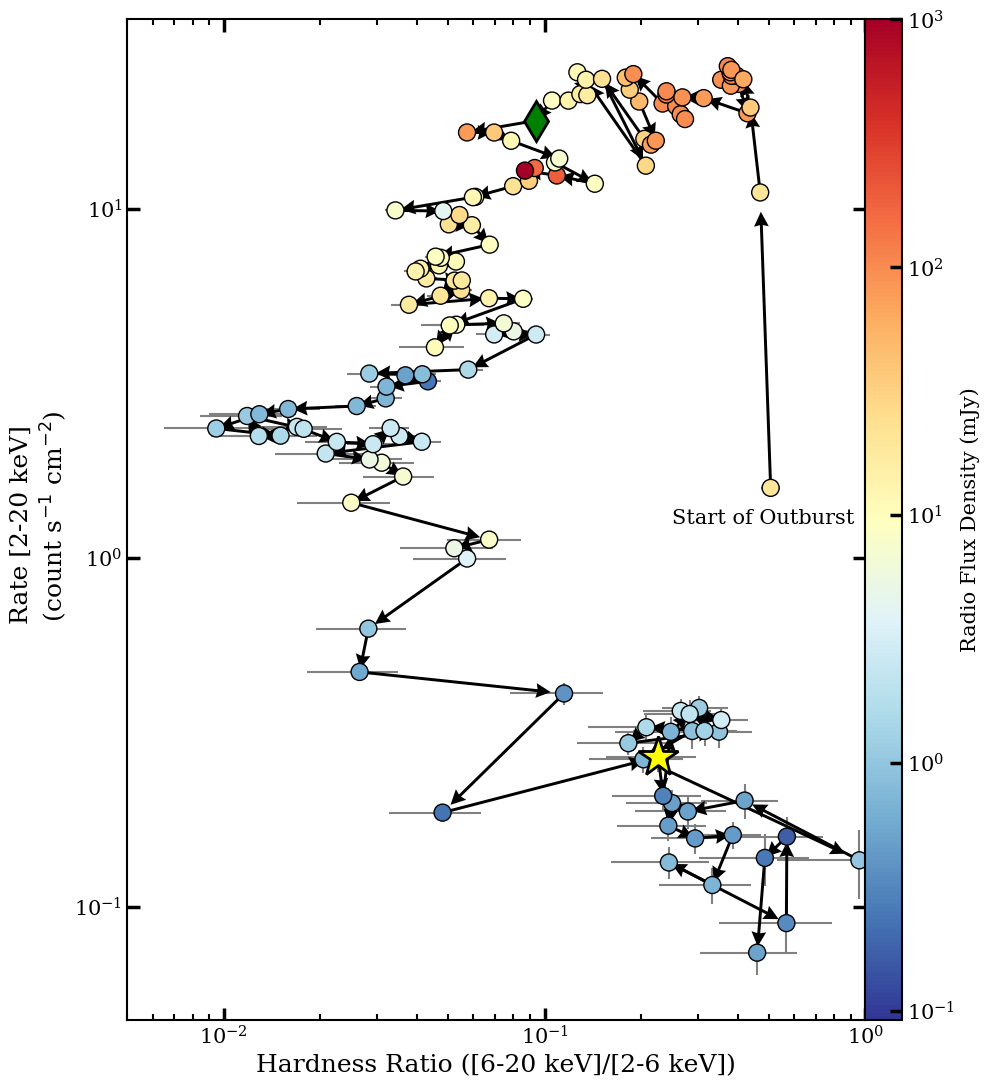

In [8]:
# Transition times for state changes
hard_to_soft = Time('2023-10-05T12:00:00', format='isot')  # Transition from hard to soft state (ATel 16273)
soft_to_hard = Time('2024-03-15T12:00:00', format='isot')  # Transition from soft to hard state (ATel 16541)

# Initialize the Hardness-Intensity Diagram (HID) plot and color bar
cm = mpl.colormaps['RdYlBu_r']  # Colormap for the radio flux density
fig, ax = plt.subplots(1, figsize=(10, 13))  # Create a single subplot with specified size
fig.set_facecolor('white')  # Set the figure background color to white
ax = np.atleast_1d(ax)  # Ensure `ax` is always an array for consistent handling

# This variable is unused but retains the length of the HID array
f = len(HID[:, 0])

# Interpolate radio flux values to match HID time points for the color bar
radio_t = data['Midpoint (MJD)'][scaled_index]  # Radio observation times
radio_f = flux_scaled[scaled_index]  # Scaled radio flux values
radio_HID = np.interp(HID[:f, 0], radio_t, radio_f)  # Interpolate radio flux to HID times
radio_HID[radio_HID > 1e3] = 1e3  # Cap radio flux values at 1000 mJy for visualization

# Plot HID points with radio flux as the color bar
cplt = ax[0].scatter(
    HID[:f, 2][::-1], HID[:f, 4][::-1],  # Hardness ratio and total flux (reversed for time evolution)
    c=radio_HID[::-1],  # Color based on interpolated radio flux
    zorder=10000, ec='k', cmap=cm, norm='log', s=150  # Styling options
)
ax[0].errorbar(
    HID[:f, 2], HID[:f, 4],  # Hardness ratio and total flux
    xerr=HID[:f, 3], yerr=HID[:f, 5],  # Errors in hardness ratio and total flux
    fmt='.', zorder=100, color='grey'  # Styling options
)

# Add arrows to represent time-domain evolution in the HID
ax[0].quiver(
    HID[:f-1, 2], HID[:f-1, 4],  # Starting points of arrows
    (HID[1:f, 2] - HID[:f-1, 2]), (HID[1:f, 4] - HID[:f-1, 4]),  # Arrow directions
    scale_units='xy', angles='xy', scale=1.07, color='black', zorder=1000, width=4e-3, headwidth=5
)

# Add a label for the start of the outburst
ax[0].text(
    0.250, 1.25, 'Start of Outburst',  # Position and text
    bbox=dict(facecolor='none', edgecolor='white', pad=3.0)  # Styling options
)

# Add a color bar for the radio flux density
divider = make_axes_locatable(ax[0])  # Create a divider for the axis
cax = divider.append_axes('right', size='5%', pad=0)  # Add a color bar axis
cbar = fig.colorbar(cplt, cax=cax, label="Radio Flux Density (mJy)")  # Add the color bar

# Highlight the transition times on the HID
index = np.argmin(abs(HID[:, 0] - hard_to_soft.mjd))  # Find the closest HID point to the hard-to-soft transition
ax[0].errorbar(
    HID[index, 2], HID[index, 4], fmt='d', c='green', ms=20, mec='k', mew=2, zorder=1e6  # Plot the transition point
)

index = np.argmin(abs(HID[:, 0] - soft_to_hard.mjd))  # Find the closest HID point to the soft-to-hard transition
ax[0].errorbar(
    HID[index, 2], HID[index, 4], fmt='*', c='yellow', ms=30, mec='k', mew=2, zorder=1e6  # Plot the transition point
)

# Format the HID plot
ax[0].set_ylabel('Rate [2-20 keV] \n (count s$^{-1}$ cm$^{-2}$)', fontsize=18)  # Y-axis label
ax[0].set_xlabel(r'Hardness Ratio $\left(\frac{[\text{6-20 keV}]}{[\text{2-6 keV}]}\right)$', fontsize=18)  # X-axis label
ax[0].set_xlabel(r'Hardness Ratio ([6-20 keV]/[2-6 keV])', fontsize=18)  # Alternative X-axis label
ax[0].set_yscale('log')  # Set Y-axis to logarithmic scale
ax[0].set_xscale('log')  # Set X-axis to logarithmic scale
ax[0].tick_params(labelbottom=True)  # Enable bottom tick labels

# Set the X-axis limits
ax[0].set_xlim(5e-3, 1)

# Display the plot
plt.show()

## Plot the giant (some would say MONOLITHIC) radio light curve from all of the data

/tmp/ipykernel_175925/951613067.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


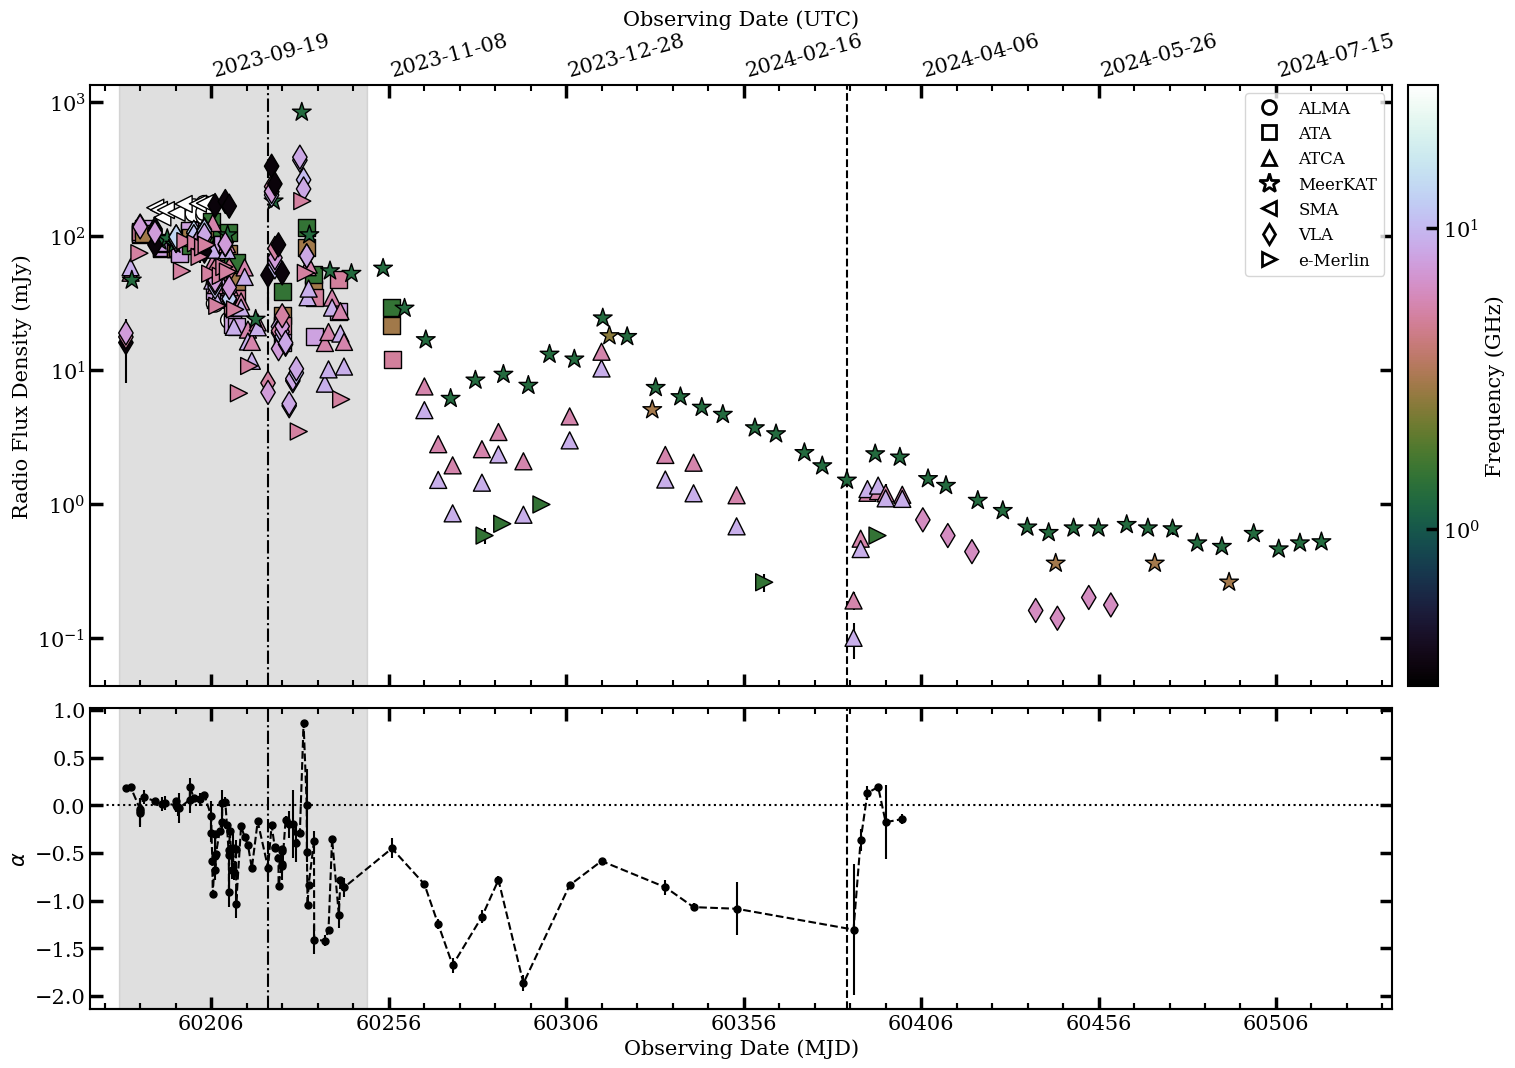

In [9]:
from matplotlib.lines import Line2D

# Function to align the x-axis of one subplot with another
# This is useful when sharing the x-axis between multiple subplots
def align_axis_x(ax, ax_target):
    """Make x-axis of `ax` aligned with `ax_target` in figure"""
    posn_old, posn_target = ax.get_position(), ax_target.get_position()  # Get positions of both axes
    ax.set_position([posn_target.x0, posn_old.y0, posn_target.width, posn_old.height])  # Align positions

# Initialize the plot with two subplots
# The top panel will show radio flux densities, and the bottom panel will show spectral indices
fig, ax = plt.subplots(2, figsize=(20, 12), sharex=True, gridspec_kw={'hspace': 0.05, 'height_ratios': [1.0, 0.5]})
ax = np.atleast_1d(ax)  # Ensure `ax` is always an array for consistent handling

# Define marker symbols, sizes, and colormap for the telescopes
symbol = ['o', 's', '^', '*', '<', 'd', '>']  # Marker symbols for different telescopes
ms = [150, 150, 150, 200, 150, 150, 150]  # Marker sizes
cm = mpl.colormaps['cubehelix']  # Colormap for frequency

# Plot radio flux densities in the top panel
for k, tele in enumerate(np.unique(data['Telescope'])):  # Iterate over unique telescopes
    index = np.where(data['Telescope'] == tele)[0]  # Get indices for the current telescope
    # Scatter plot for radio flux densities, colored by frequency
    cplt = ax[0].scatter(
        data['Midpoint (DT)'][index], data['Integrated flux (mJy)'][index],
        c=data['Frequency (GHz)'][index], zorder=10000, ec='k', cmap=cm, norm='log',
        s=ms[k], label=f'{tele}', marker=symbol[k], vmin=0.3, vmax=30.
    )
    # Add error bars for the flux densities
    ax[0].errorbar(
        data['Midpoint (DT)'][index], data['Integrated flux (mJy)'][index],
        data['Error (mJy)'][index], fmt='.', ecolor='k'
    )

# Plot spectral indices in the bottom panel
alpha_index = np.argsort(alpha_mjd)  # Sort spectral indices by time
ax[1].errorbar(
    Time(alpha_mjd[alpha_index], format='mjd').datetime, alpha_arr[alpha_index],
    alpha_err_arr[alpha_index], fmt='o--', mec='k', ecolor='k', color='k', ms=5
)
ax[1].axhline(0.0, ls=':', c='k')  # Add a horizontal line at alpha = 0

# Highlight reported state transitions in both plots
for ax_i in ax:
    ax_i.axvline(Time(60385, format='mjd').datetime, ls='--', c='k')  # Hard-to-soft transition
    ax_i.axvline(Time(60222, format='mjd').datetime, ls='-.', c='k')  # Soft-to-hard transition
    # Highlight a specific time range (e.g., zoomed-in region)
    ax_i.axvspan(Time(60180, format='mjd').datetime, Time(60250, format='mjd').datetime, color='grey', alpha=0.25)

# Manually specify legend elements for the telescopes
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='ALMA', mec='k', mfc='w', mew=2, markersize=10),
    Line2D([0], [0], marker='s', color='w', label='ATA', mec='k', mfc='w', mew=2, markersize=10),
    Line2D([0], [0], marker='^', color='w', label='ATCA', mec='k', mfc='w', mew=2, markersize=10),
    Line2D([0], [0], marker='*', color='w', label='MeerKAT', mec='k', mfc='w', mew=2, markersize=15),
    Line2D([0], [0], marker='<', color='w', label='SMA', mec='k', mfc='w', mew=2, markersize=10),
    Line2D([0], [0], marker='d', color='w', label='VLA', mec='k', mfc='w', mew=2, markersize=10),
    Line2D([0], [0], marker='>', color='w', label='e-Merlin', mec='k', mfc='w', mew=2, markersize=10)
]
ax[0].legend(handles=legend_elements, fontsize=12, ncol=1)  # Add the legend to the top panel

# Format the top panel
ax[0].set_yscale('log')  # Set y-axis to logarithmic scale
ax[0].set_ylabel('Radio Flux Density (mJy)')  # Add y-axis label

# Format the bottom panel
ax[1].set_ylabel(r'$\alpha$')  # Add y-axis label for spectral index
ax[1].tick_params(labelbottom=False)  # Disable x-axis labels for the bottom panel

# Add a color bar for the frequency in the top panel
fig.colorbar(cplt, ax=ax[0], label="Frequency (GHz)", shrink=1, pad=0.01)

# Format the x-axis to include UTC on top and MJD on the bottom
FormatAxis(ax, [data['Midpoint (MJD)'][0], data['Midpoint (MJD)'].iloc[-1] + 10], interval=50)

# Align the x-axis of the bottom panel with the top panel
align_axis_x(ax[1], ax[0])

# Display the plot
plt.show()

## Plot zoomed in Light Curve of rapid flaring

/tmp/ipykernel_175925/951613067.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


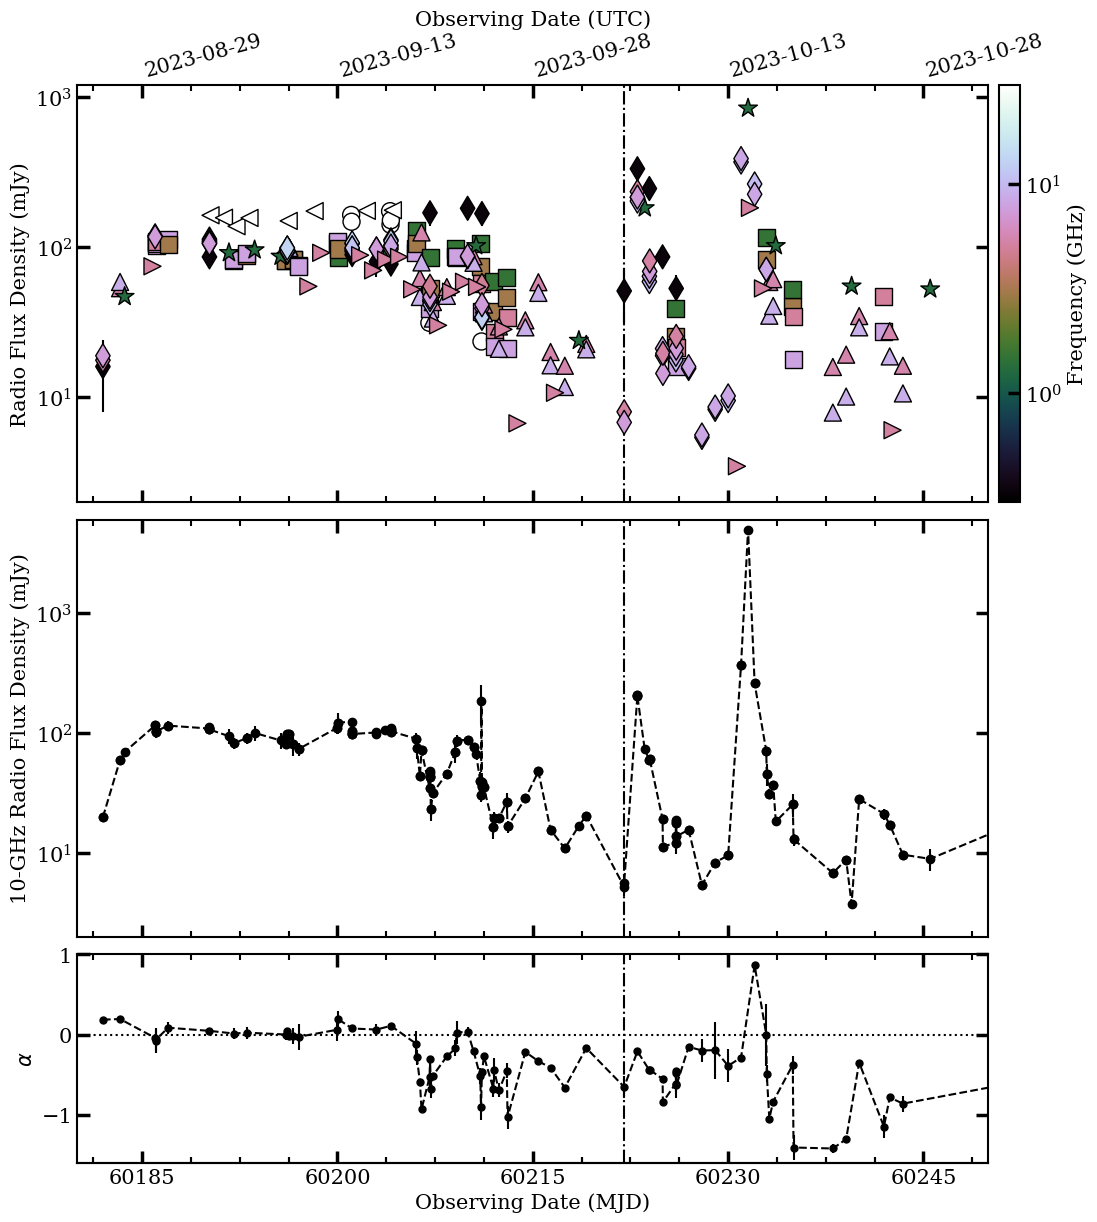

In [10]:
# Create a figure with three subplots
# Top panel: Radio flux densities
# Middle panel: Scaled 10-GHz flux densities
# Bottom panel: Spectral indices
fig, ax = plt.subplots(3, figsize=(14, 14), sharex='col', gridspec_kw={'hspace': 0.05, 'height_ratios': [1.0, 1.0, 0.5]})
ax = np.atleast_1d(ax)  # Ensure `ax` is always an array for consistent handling

# Plot radio flux densities in the top panel
z = 0  # Counter for telescope markers
for k, tele in enumerate(np.unique(data['Telescope'])):  # Iterate over unique telescopes
    index = np.where(data['Telescope'] == tele)[0]  # Get indices for the current telescope
    # Scatter plot for radio flux densities, colored by frequency
    cplt = ax[0].scatter(
        data['Midpoint (DT)'][index], data['Integrated flux (mJy)'][index],
        c=data['Frequency (GHz)'][index], zorder=10000, ec='k', cmap=cm, norm='log',
        s=ms[k], label=f'{tele}', marker=symbol[k], vmin=0.3, vmax=30.
    )
    # Add error bars for the flux densities
    ax[0].errorbar(
        data['Midpoint (DT)'][index], data['Integrated flux (mJy)'][index],
        data['Error (mJy)'][index], fmt='.', ecolor='k'
    )
    z += 1  # Increment the counter

# Mark state transitions in all panels
for ax_i in ax:
    ax_i.axvline(Time(60385, format='mjd').datetime, ls='--', c='k')  # Hard-to-soft transition
    ax_i.axvline(Time(60222, format='mjd').datetime, ls='-.', c='k')  # Soft-to-hard transition

# Plot scaled 10-GHz flux densities in the middle panel
ax[1].errorbar(
    data['Midpoint (DT)'][scaled_index], flux_scaled[scaled_index],
    flux_scaled_err[scaled_index], color='k', fmt='o--'
)

# Plot spectral indices in the bottom panel
alpha_index = np.argsort(alpha_mjd)  # Sort spectral indices by time
ax[2].errorbar(
    Time(alpha_mjd[alpha_index], format='mjd').datetime, alpha_arr[alpha_index],
    alpha_err_arr[alpha_index], fmt='o--', mec='k', ecolor='k', color='k', ms=5
)
ax[2].axhline(0.0, ls=':', c='k')  # Add a horizontal line at alpha = 0

# Format the top panel
ax[0].set_yscale('log')  # Set y-axis to logarithmic scale
ax[0].set_ylabel('Radio Flux Density (mJy)')  # Add y-axis label
ax[0].set_ylim(2.0, 1200)  # Set y-axis limits

# Format the middle panel
ax[1].set_yscale('log')  # Set y-axis to logarithmic scale
ax[1].set_ylabel('10-GHz Radio Flux Density (mJy)')  # Add y-axis label
ax[1].set_ylim(2.0, 6000)  # Set y-axis limits

# Format the bottom panel
ax[2].set_ylabel(r'$\alpha$')  # Add y-axis label for spectral index
ax[2].set_ylim(-1.6, 1.0)  # Set y-axis limits
ax[2].tick_params(labelbottom=False)  # Disable x-axis labels for the bottom panel

# Format the x-axis to include UTC on top and MJD on the bottom
FormatAxis(ax, [60180, 60250], dt=0, interval=15)

# Add a color bar for the frequency in the top panel
fig.colorbar(cplt, ax=ax[0], label="Frequency (GHz)", shrink=1, pad=0.01)

# Align the x-axis of the middle and bottom panels with the top panel
align_axis_x(ax[1], ax[0])
align_axis_x(ax[2], ax[0])

# Display the plot
plt.show()